In [629]:
import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

# file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output.npy")


from funcs.reloads import Reloader

import importlib
import classes.utilities
from classes.utilities import Utilities

importlib.reload(classes.utilities)
from classes.utilities import Utilities

rl = Reloader()
NSP = rl.nsp()

import funcs.gaborpyr
importlib.reload(funcs.gaborpyr)
import funcs.gaborpyr

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdc

In [630]:
from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
    select_filters,
    cut_paste_mask,
    location_based_selection,
    filts_per_freq,
    orient_boolmask,
)

### Turn this into functions


In [10]:
subject = "subj01"
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees
peri_ecc = 0
peri_angle = 0

cirkel = circle_stim((425, 425), (1 * pix_per_deg), (212, 212))

gauss = isotropic_gaussian(
    dims=(425, 425), sigma=pix_per_deg / 4
)  # Justify this 2.5 factor

checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)


gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

if peri_ecc != 0 and peri_angle != 0:
    print(
        f"Working with a peripheral patch at {peri_ecc} degrees eccentricity and {peri_angle} degrees angle"
    )
    peri_patch = cut_paste_mask(
        gauss_check_stack, peri_angle, peri_ecc, verbose=False, plot=False
    )
    peri_gauss = cut_paste_mask(
        np.stack([gauss, gauss], axis=0),
        peri_angle,
        peri_ecc,
        verbose=False,
        plot=False,
    )
    gauss_check_stack = np.stack([peri_gauss, peri_patch], axis=0)


# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
spat_freqs = [
    4.2,
    8.4,
    16.8,
    33.6,
]  #### THis was the previous list of spatial frequencies
# spat_freqs = [8.4, 16.8, 33.6] # Extreme option with only 2 spatial frequencies

spat_dirs = tuple(range(0, 180, 30))  # Original one
# spat_dirs = tuple(range(0,180,20)) # non-lenient one
filter_space = 1.5  # used to be 1.5

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(
    stimulus=gauss_check_stack,
    spatial_frequencies=spat_freqs,  # 1, 2, 4, 8 cycles per degree
    # spatial_frequencies=[33.6], # 1, 2, 4, 8 cycles per degree
    # spatial_orientations=(0, 45, 90, 135),
    spatial_orientations=spat_dirs,
    sf_gauss_ratio=0.25,  # ratio of spatial frequency to gaussian s.d.
    max_spatial_env=(1 / 8.4),  # max sd of gaussian envelope
    filter_spacing=filter_space,
    include_edges=False,  # Should be false, we're not interested in the edges
    spatial_phase_offset=0,
)

checkpyramid.view.nfilters

### THis is important code for the direction filtering

# Get all directions
directions = [
    checkpyramid.view.filters[i]["direction"] for i in range(checkpyramid.view.nfilters)
]

# Get unique directions
unique_directions = np.unique(directions)

# Initialize an empty array to store the masks
direction_masks = np.zeros(
    (len(unique_directions), checkpyramid.view.nfilters), dtype=bool
)

# Create a mask for each unique direction
for i, direction in enumerate(unique_directions):
    direction_masks[i] = np.array(directions) == direction

In [11]:
print(checkpyramid.nfilters)

61992


In [12]:
gauss_output = np.load(
    "/home/rfpred/data/custom_files/visfeats/gabor_pyramid/gauss_checker_output_all_imgs_sf4_dir6.npy"
)
# gauss_output = np.load("/home/rfpred/data/custom_files/visfeats/peripheral/ecc2.0_angle330/gabor_pyramid/gauss_checker_output_all_imgs_sf4_dir6.npy")
# Figure out how many filters there are per spatial frequency
filters_per_freq = []
for sf in spat_freqs:

    all_filters = checkpyramid.view.filters
    count = sum(1 for d in all_filters if d.get("spatial_freq") == sf)
    filters_per_freq.append(count)

filters_per_freq

output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=spat_freqs,
        direction_masks=direction_masks,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=99.95,  # Het moet maar
        plot=False,
        verbose=True,
    )
)

# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)


# The indices for the filters that are within the patch
# filter_indices = np.where(filter_selection == True)[0]
filter_indices = np.where(full_filter == True)[0]

Direction 0, Spatial frequency 0: percentile = 1.8240954190492742, number of values > percentile = 1
Direction 0, Spatial frequency 1: percentile = 1.5013992667198186, number of values > percentile = 2
Direction 0, Spatial frequency 2: percentile = 1.2103076606988916, number of values > percentile = 6
Direction 0, Spatial frequency 3: percentile = 0.8363741420209418, number of values > percentile = 24
Direction 1, Spatial frequency 0: percentile = 1.825953383743774, number of values > percentile = 1
Direction 1, Spatial frequency 1: percentile = 1.5016109803318987, number of values > percentile = 2
Direction 1, Spatial frequency 2: percentile = 1.2105409061312693, number of values > percentile = 6
Direction 1, Spatial frequency 3: percentile = 0.8616297617554793, number of values > percentile = 24
Direction 2, Spatial frequency 0: percentile = 1.8259534269571416, number of values > percentile = 1
Direction 2, Spatial frequency 1: percentile = 1.5016109803318987, number of values > perc

(198, 425, 425)


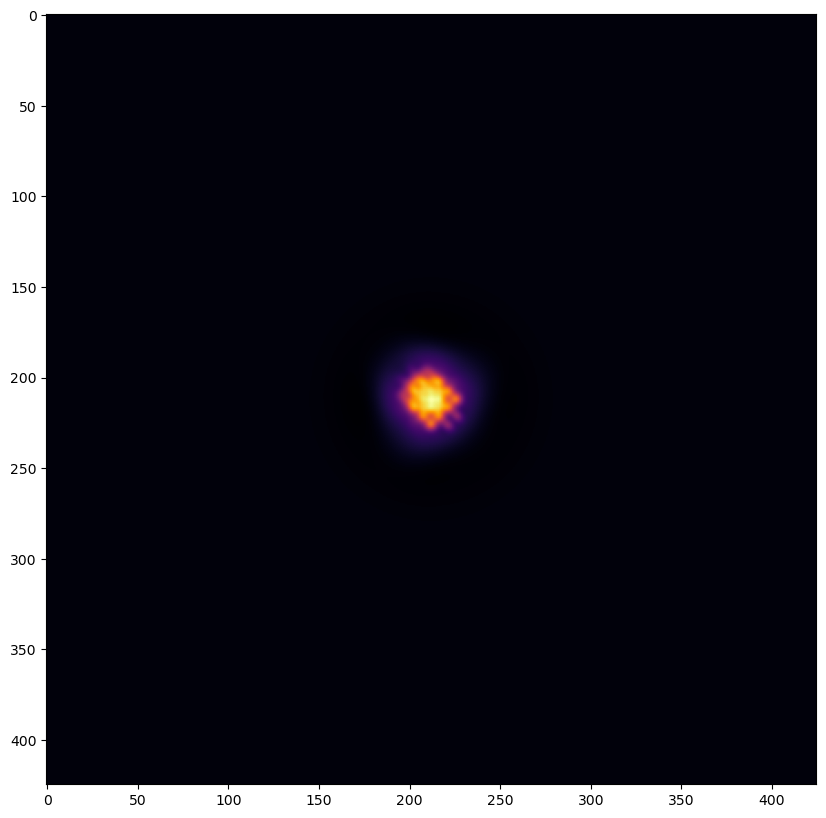

In [13]:
filt_stack = []

for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    for filt_no in range(len(filter_selection_dictlist[dir])):

        fdict = filter_selection_dictlist[dir][filt_no]

        aars = moten.core.mk_3d_gabor(
            vhsize=(425, 425),
            centerh=fdict["centerh"],
            centerv=fdict["centerv"],
            direction=fdict["direction"],
            spatial_freq=fdict["spatial_freq"],
            spatial_env=fdict["spatial_env"],
            temporal_freq=fdict["temporal_freq"],
            filter_temporal_width=fdict["filter_temporal_width"],
            aspect_ratio=fdict["aspect_ratio"],
            stimulus_fps=fdict["stimulus_fps"],
            spatial_phase_offset=fdict["spatial_phase_offset"],
        )

        filt_stack.append(aars[1])


filt_stack = np.array(filt_stack)
print(filt_stack.shape)

fig, axes = plt.subplots(figsize=(10, 10))
plt.imshow(np.mean(filt_stack, axis=0), cmap="inferno")

212.0 212.0
(162, 262, 162, 262)


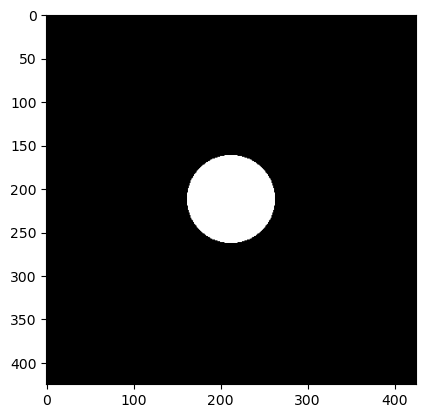

In [14]:
# x_pix, y_pix = [(coord * pix_per_deg + 212) for coord in list(NSP.utils.ecc_angle_to_coords(2, 210))]
# x_rad, y_rad = NSP.utils.ecc_angle_to_coords(2, 330)
x_rad, y_rad = NSP.utils.ecc_angle_to_coords(0, 0)
x_pix = x_rad * pix_per_deg + 212
y_pix = 212 - y_rad * pix_per_deg
print(x_pix, y_pix)
circ = NSP.utils.make_circle_mask(425, y_pix, x_pix, 1 * pix_per_deg)

plt.imshow(circ, cmap="binary_r")

bounds = NSP.utils.get_bounding_box(circ)

print(bounds)

(33, 425, 425)


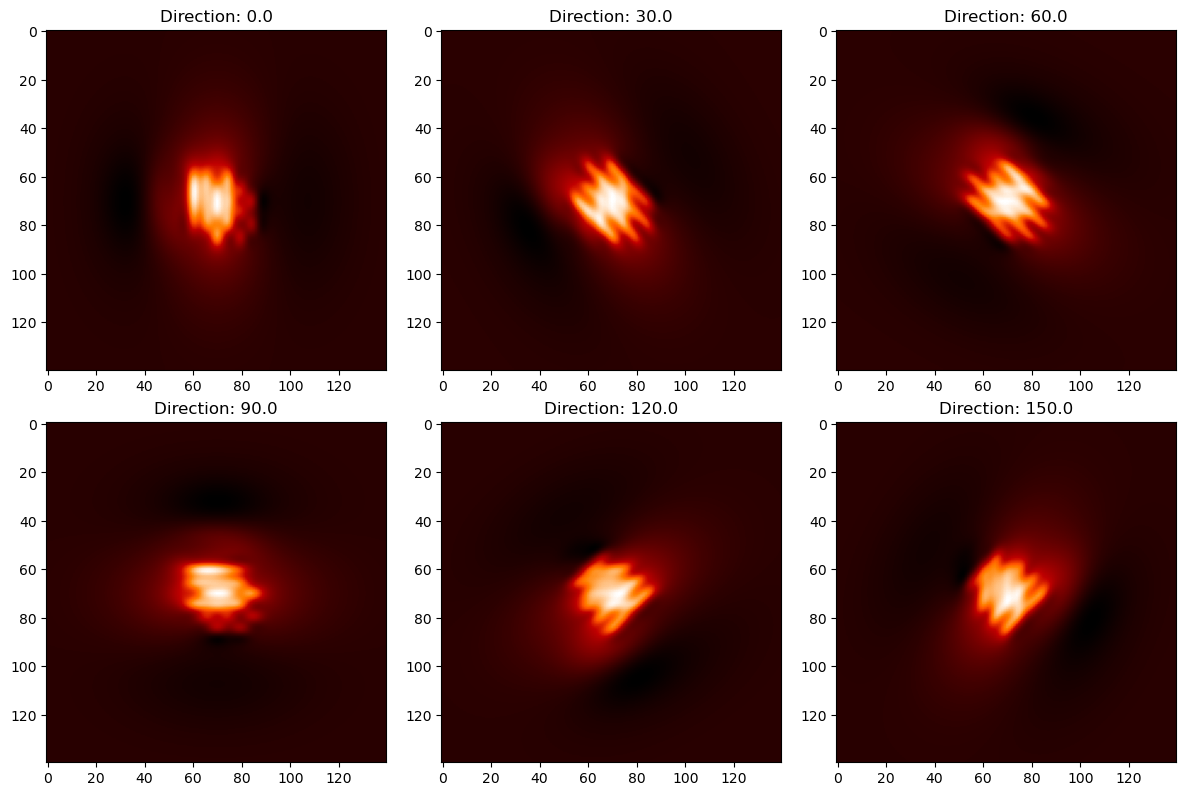

In [15]:
margin = 20
# filt_stack = []
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    filt_stack = []

    for filt_no in range(len(filter_selection_dictlist[dir])):
        # for filt_no in [20]:
        fdict = filter_selection_dictlist[dir][filt_no]

        aars = moten.core.mk_3d_gabor(
            vhsize=(425, 425),
            centerh=fdict["centerh"],
            centerv=fdict["centerv"],
            direction=fdict["direction"],
            spatial_freq=fdict["spatial_freq"],
            spatial_env=fdict["spatial_env"],
            temporal_freq=fdict["temporal_freq"],
            filter_temporal_width=fdict["filter_temporal_width"],
            aspect_ratio=fdict["aspect_ratio"],
            stimulus_fps=fdict["stimulus_fps"],
            spatial_phase_offset=fdict["spatial_phase_offset"],
        )

        filt_stack.append(aars[1])

    # Calculate the mean heatmap
    mean_heatmap = np.mean(filt_stack, axis=0)

    # Determine the subplot row and column
    row = dir_no // 3
    col = dir_no % 3

    # Plot the mean heatmap in the appropriate subplot
    ax[row, col].imshow(
        mean_heatmap[
            (bounds[2] - margin) : (bounds[3] + margin),
            (bounds[0] - margin) : (bounds[1] + margin),
        ],
        cmap="gist_heat",
    )

    # Set the title of the subplot to include the direction info
    ax[row, col].set_title(f"Direction: {fdict['direction']}")

filt_stack = np.array(filt_stack)
print(filt_stack.shape)
fig.tight_layout()

# Optimisation of gabor filter selection


### Create a stimulus that represents the visual region of which we want to quantify the content. To this end we'll convolve a nested checker stimulus with an isotropic gaussian.


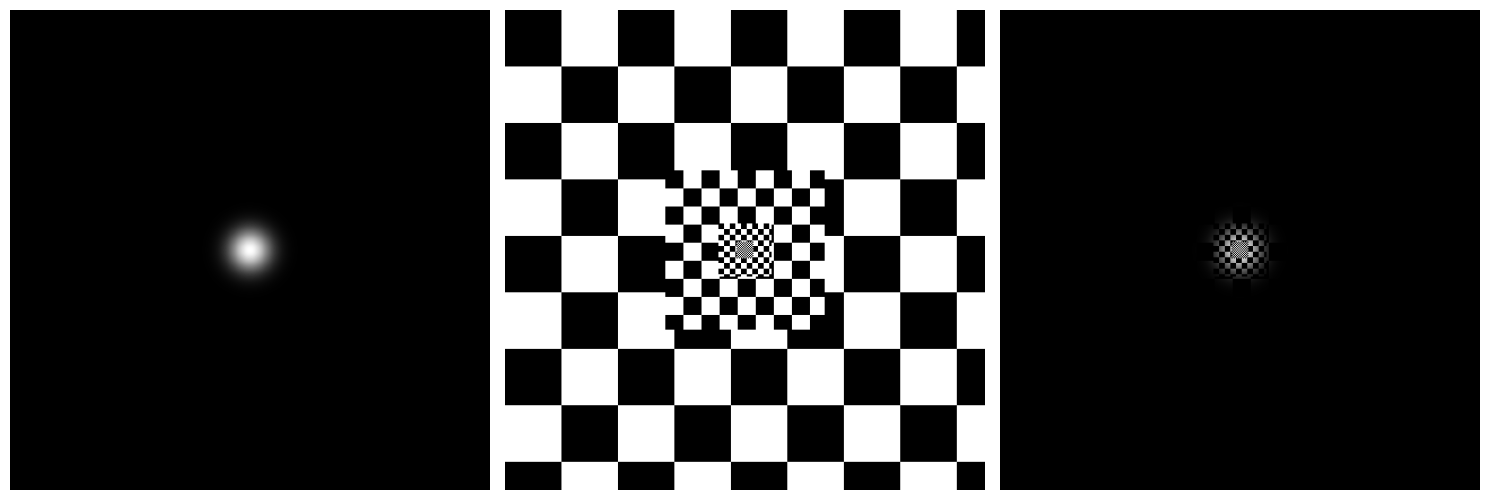

In [32]:
gauss = isotropic_gaussian(
    dims=(425, 425), sigma=pix_per_deg / 4
)  # Justify this 2.5 factor

checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap="gist_gray")
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

### Here we build our gabor filter pyramid given a set of defined parameters.


In [631]:
# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
pyr_pars = {
    "spatial_frequencies": [4.2, 8.4, 16.8, 33.6,],  # 1, 2, 4, 8 cycles per degree (octave)
    "spatial_orientations": tuple(range(0, 180, 30)),  # 0, 45, 90, 135
    "sf_gauss_ratio": .25,  # ratio of spatial frequency to gaussian s.d.
    "max_spatial_env": 1 / 8.4,  # max sd of gaussian envelope
    "filter_spacing": 1,  # filter spacing in degrees
    "spatial_phase_offset": 0,  # spatial phase offset in degrees
}

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(
    stimulus=gauss_check_stack, **pyr_pars
)

checkpyramid.view.nfilters

140952

### I'll try to filter out the filters that fall outside the patch region beforehand to reduce computational costs (time mostly)


[0.3811764705882353, 0.6164705882352941, 0.3811764705882353, 0.6164705882352941]


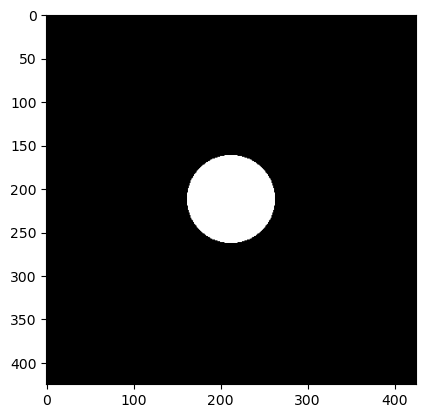

In [603]:
circ, bounds_prc = NSP.utils.boolmask(
    pix_dims=425,
    deg_dims=8.4,
    eccentricity=0,
    angle=0,
    radius=1,
    plot=True,
    return_bounds=True,
    bound_units="prc",
)

print(bounds_prc)

### Select only those gabor filters that fall within the patch region

In [632]:
filts_in_patch, filts_boolvec = location_based_selection(checkpyramid, bounds_prc, verbose=True)

Original number of filters: 140952
Number of filters encapsulated by our patch: 7464


### Project the gaussian checkerboard stimulus to be processed by the selection of filters

In [633]:
# Project the stimulus onto the filters that fall inside the patch region
gauss_output = checkpyramid.project_stimulus(gauss_check_stack, filters=filts_in_patch)

project_stimulus: 100%|██████████| 7464/7464 [01:42<00:00, 72.95it/s]


### Get the output from ALL filters to the gaussian checker stimulus.


In [27]:
# Get output from all the filters, don't do this, it takes a lot of time.
# gauss_output = checkpyramid.project_stimulus(gauss_check_stack)

project_stimulus:  25%|██▍       | 9003/36168 [02:21<06:15, 72.32it/s]

### Check how many filters each spatial frequency contains

In [634]:
filters_per_freq = filts_per_freq(pyr_pars, filts_in_patch)
print(filters_per_freq)

[54, 294, 1350, 5766]


### Inspect the spatial frequency specific filter outputs for the gaussian checkerboard stimulus

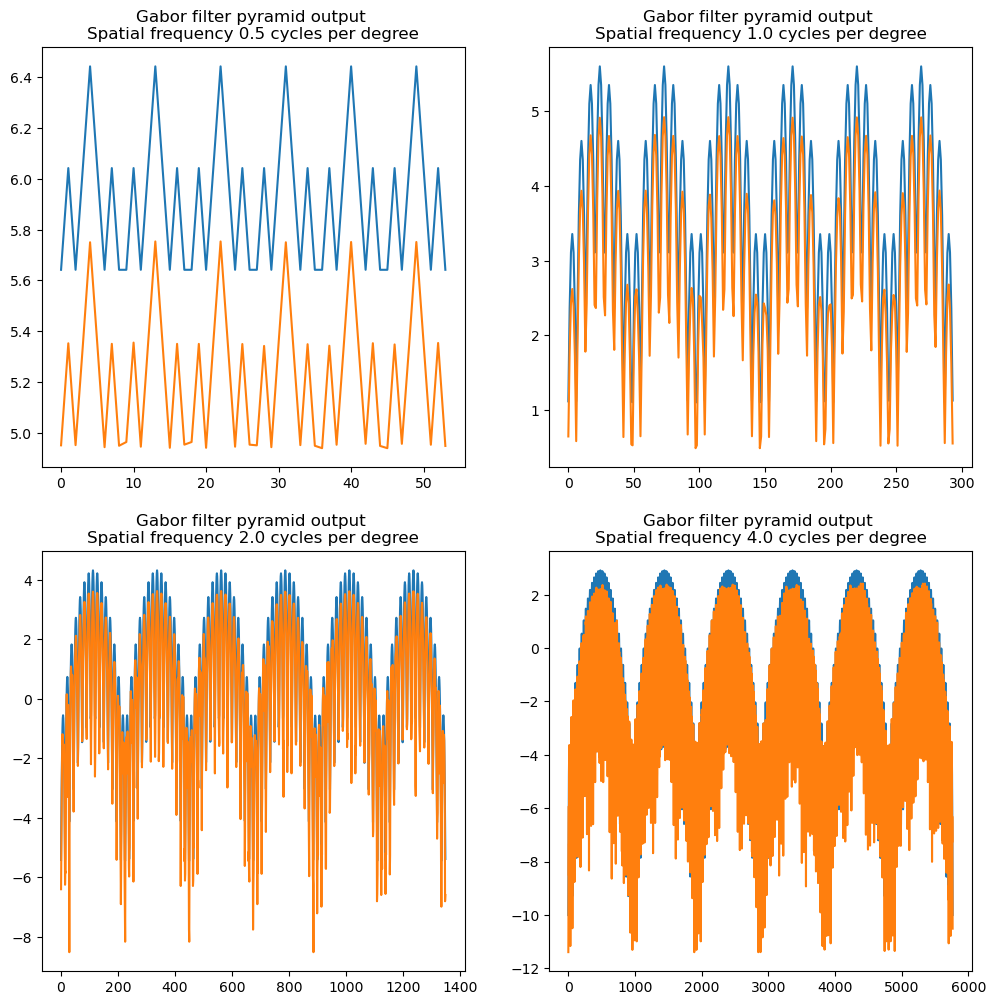

In [635]:
plot_filter_outputs(
    sel_output=gauss_output,
    filters_per_freq_sel=filters_per_freq,
    spat_freqs=spat_freqs,
    img_indices=[0, 1],
)

### What does this code do? is this not included in the select filters function?


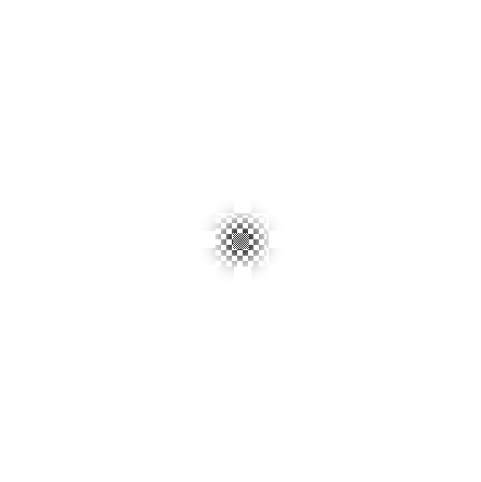

Spatial frequency 0: percentile = 1.309629312634468, number of values > percentile = 2
Spatial frequency 1: percentile = 1.3482429566383365, number of values > percentile = 2
Spatial frequency 2: percentile = 2.3682522773742676, number of values > percentile = 6
Spatial frequency 3: percentile = 4.243169784545898, number of values > percentile = 26
Filter includes 36 out of 36168 filters


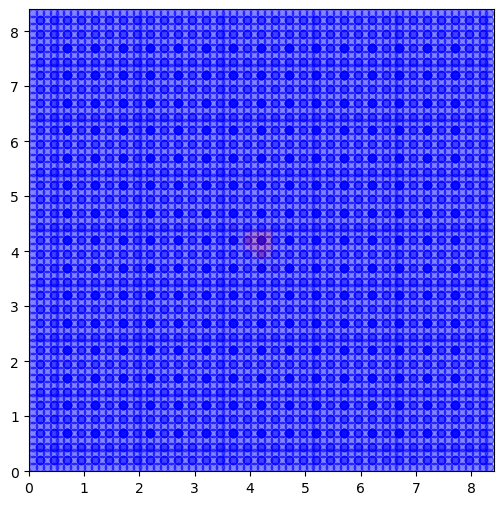

In [35]:
plaat_nummer = 1

output = gauss_output[plaat_nummer]
show(gauss_check_stack[plaat_nummer], figsize=(6, 6))

n_spatfreqs = len(spat_freqs)
nth_percentile = 99.9  # Change this to your desired percentile

# normalise the output for every spatial frequency separately
from scipy.stats import zscore as zs

start = 0
circle_output_norm = []
for i in range(n_spatfreqs):
    end = start + filters_per_freq[i]
    circle_output_norm.append(zs(output[start:end]))
    start = end

# Calculate the nth percentile for each spatial frequency and create a boolean mask
# TODO: save these in a list, already kinda did so
dot_filter = []
filters_per_freq_sel = []
for i in range(n_spatfreqs):
    percentile = np.percentile(circle_output_norm[i], nth_percentile)
    mask = circle_output_norm[i] > percentile
    dot_filter.append(mask)
    n_filters = np.sum(mask)
    filters_per_freq_sel.append(n_filters)
    print(
        f"Spatial frequency {i}: percentile = {percentile}, number of values > percentile = {n_filters}"
    )

dot_filter = np.concatenate(dot_filter)

filter_list = list(np.array(checkpyramid.view.filters)[dot_filter])

print(
    f"Filter includes {np.sum(dot_filter)} out of {checkpyramid.view.nfilters} filters"
)

plot_filter_locations(
    gabor_pyramid=checkpyramid, in_range=dot_filter, pixdims=(425, 425)
)

### Get a boolean mask for every separate gabor filter orientation

In [636]:
orient_mask = orient_boolmask(filts_in_patch)
orient_mask

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

In [648]:
output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        filter_list=filts_in_patch,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=pyr_pars["spatial_frequencies"],
        direction_masks=orient_mask,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=99,  # Het moet maar
        # percentile_cutoff=0,  # Het moet maar
        best_n=None,
        plot=False,
        verbose=True,
    )
)

# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)

Direction 0, Spatial frequency 0: number of values > percentile = 1
Direction 0, Spatial frequency 1: number of values > percentile = 3
Direction 0, Spatial frequency 2: number of values > percentile = 14
Direction 0, Spatial frequency 3: number of values > percentile = 58
Direction 1, Spatial frequency 0: number of values > percentile = 1
Direction 1, Spatial frequency 1: number of values > percentile = 3
Direction 1, Spatial frequency 2: number of values > percentile = 14
Direction 1, Spatial frequency 3: number of values > percentile = 58
Direction 2, Spatial frequency 0: number of values > percentile = 1
Direction 2, Spatial frequency 1: number of values > percentile = 3
Direction 2, Spatial frequency 2: number of values > percentile = 14
Direction 2, Spatial frequency 3: number of values > percentile = 58
Direction 3, Spatial frequency 0: number of values > percentile = 1
Direction 3, Spatial frequency 1: number of values > percentile = 3
Direction 3, Spatial frequency 2: number o

In [649]:
print(f"Total amount of filters: {np.sum(full_filter)}")

Total amount of filters: 456


### This function is not super useful anymore as it relies on a boolean vector that is based on the original pyramid filter size, but as we already do a location based preselection, this becomes cumbersome. 

Luckily we can also use the dictionary information as input to view a filter

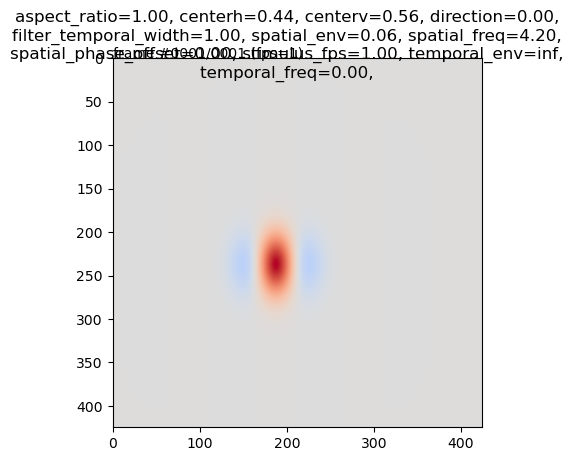

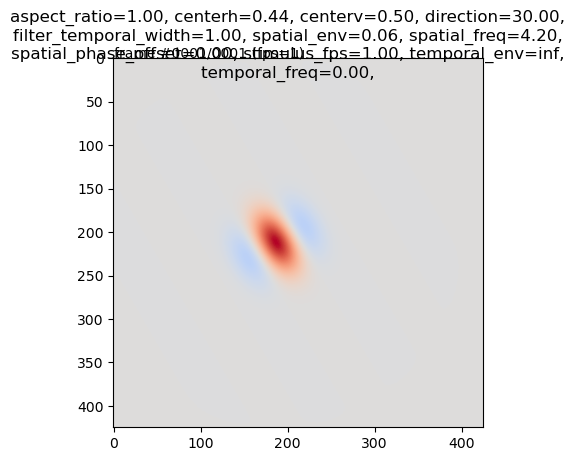

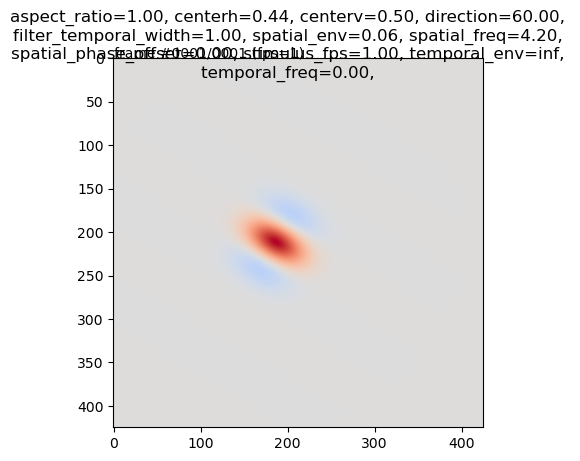

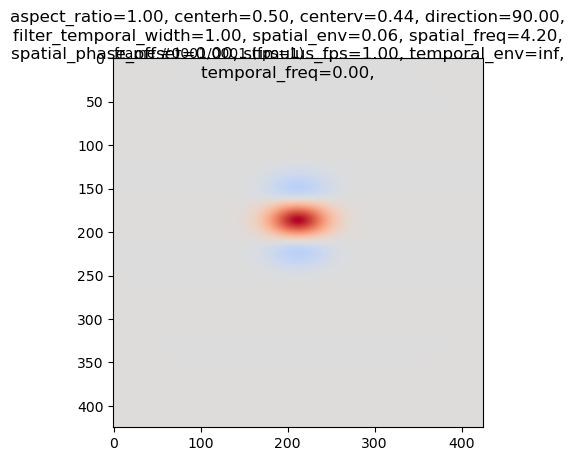

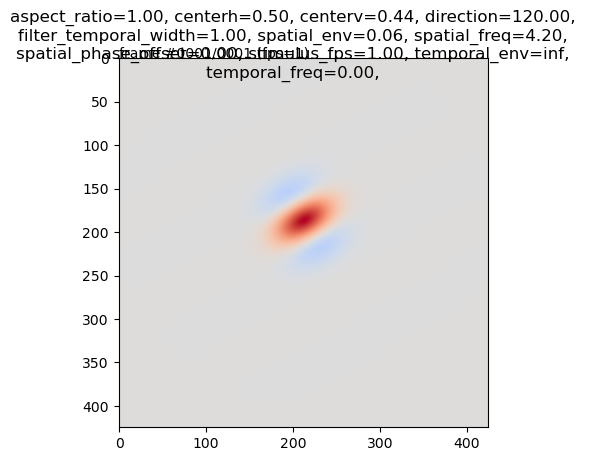

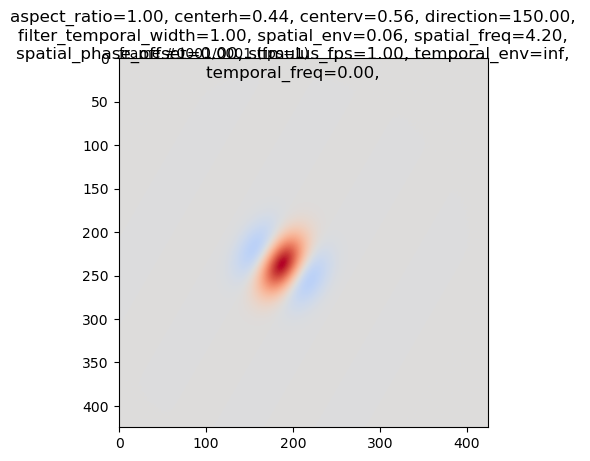

In [645]:
for this_orient in range(len(filter_selection)):
    checkpyramid.view.show_filter(filter_selection_dictlist[this_orient][1])
    plt.show()

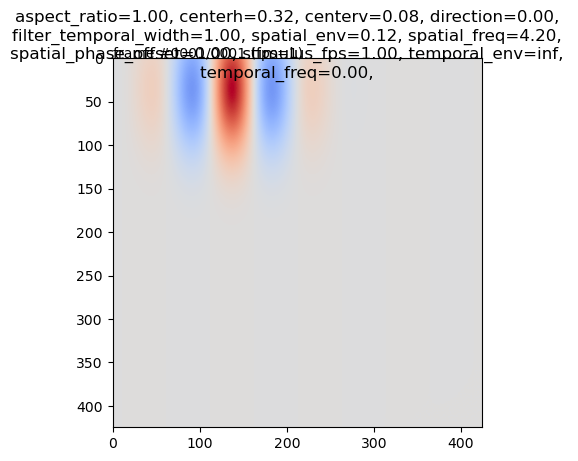

In [397]:
def show_random_filter(pyramid, filter):
    # The indices for the filters that are within the patch
    filter_indices = np.where(filter == True)[0]
    this_filter = random.choice(filter_indices)
    pyramid.view.show_filter(this_filter)
    plt.show()


# show_random_filter(checkpyramid, dot_filter)
show_random_filter(checkpyramid, filter_selection[0])

### Just a different way of visualising it, but now I also acquire a np.array version of it (which can be used to create heatmaps).

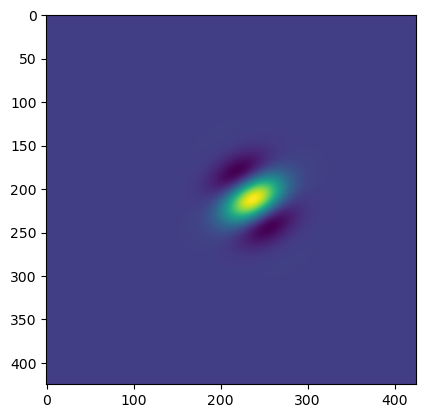

In [646]:
# filter_selection_dictlist[0]
dir = 4
filt_no = 5
fdict = filter_selection_dictlist[dir][filt_no]

# soep = moten.viz.plot_3dgabor(filter_selection_dictlist,title="soup", speed=1, time_padding=False)

aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                              centerh=fdict['centerh'],
                              # centerh=.5,
                              centerv=fdict['centerv'],
                              # centerv=.5,
                              direction=fdict['direction'],
                              spatial_freq=fdict['spatial_freq'],
                              spatial_env=fdict['spatial_env'],
                              temporal_freq=fdict['temporal_freq'],
                              filter_temporal_width=fdict['filter_temporal_width'],
                              aspect_ratio=fdict['aspect_ratio'],
                              stimulus_fps=fdict['stimulus_fps'],
                              spatial_phase_offset=fdict['spatial_phase_offset'],)

plt.imshow(aars[1])

(2418, 425, 425)


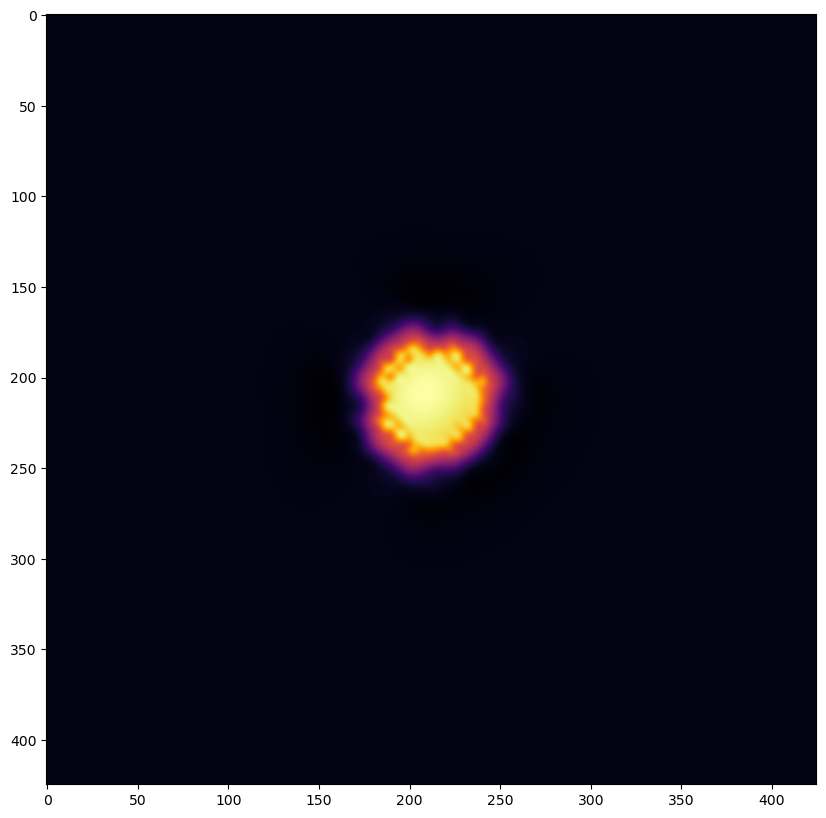

In [647]:
filt_stack = []

for dir_no, dir in enumerate(range(len(filter_selection_dictlist))):
    for filt_no in range(len(filter_selection_dictlist[dir])):
    
        fdict = filter_selection_dictlist[dir][filt_no]

        aars = moten.core.mk_3d_gabor(vhsize=(425,425), 
                                    centerh=fdict['centerh'],
                                    centerv=fdict['centerv'],
                                    direction=fdict['direction'],
                                    spatial_freq=fdict['spatial_freq'],
                                    spatial_env=fdict['spatial_env'],
                                    temporal_freq=fdict['temporal_freq'],
                                    filter_temporal_width=fdict['filter_temporal_width'],
                                    aspect_ratio=fdict['aspect_ratio'],
                                    stimulus_fps=fdict['stimulus_fps'],
                                    spatial_phase_offset=fdict['spatial_phase_offset'],)

        filt_stack.append(aars[1])


filt_stack = np.array(filt_stack)
print(filt_stack.shape)

fig, axes = plt.subplots(figsize=(10, 10))
plt.imshow(np.mean(filt_stack, axis=0), cmap="inferno")


### Continue with the analyses